### Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Data wrangling and data visualistion
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Processing text
import nltk
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Others
import numpy as np
from collections import Counter
import time
from statistics import mean

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import and read data

In [3]:
data = pd.read_csv("/content/drive/MyDrive/spam.csv",encoding = "latin-1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
data = data.dropna(how = "any", axis = 1)
data.columns = ['label','body_text']
data.head()

,label,body_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Exploratory data analysis (EDA)

In [5]:
print(f"Input data has {len(data)} rows and {len(data.columns)} columns.")

Input data has 5572 rows and 2 columns.


In [6]:
print(f"Out of {len(data)} rows, {len(data[data.label == 'spam'])} are spam and {len(data[data.label == 'ham'])} are ham.")

Out of 5572 rows, 747 are spam and 4825 are ham.


In [ ]:
total = len(data)
plt.figure(figsize = (5, 5))
plt.title("Number of spam vs ham messages")
ax = sns.countplot(x = 'label', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

In [7]:
print(f"Number of null in label: {data.label.isnull().sum()}")
print(f"Number of null in text: {data.body_text.isnull().sum()}")

Number of null in label: 0
Number of null in text: 0


### Feature engineering

In [8]:
# body_len
data['body_len'] = data.body_text.apply(lambda x: len(x) - x.count(" "))

# punct%
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100
data['punct%'] = data.body_text.apply(lambda x: count_punct(x))

data.head()

,label,body_text,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8
1,ham,Ok lar... Joking wif u oni...,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
3,ham,U dun say so early hor... U c already then say...,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1


In [10]:
# Summary statistics
data[['body_len', 'punct%']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
body_len,5572.0,65.512024,48.629795,2.0,29.0,50.0,98.0,740.0
punct%,5572.0,7.202656,6.701062,0.0,3.3,5.6,9.2,100.0


In [9]:
# Text with maximum body_len
list(data.loc[data.body_len == 740, 'body_text'])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]

In [11]:
# Text with maximum punct%
list(data.loc[data['punct%'] == 100, 'body_text'])

[':) ', ':-) :-)']

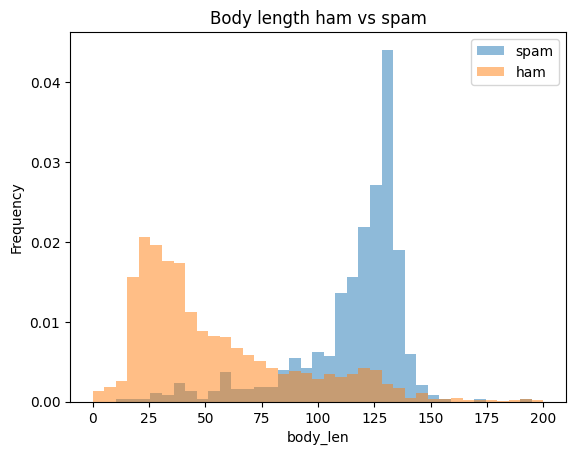

In [12]:
# Plot body_len distribution for ham and spam messages
bins = np.linspace(0, 200, 40)
data.loc[data.label == 'spam', 'body_len'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'spam')
data.loc[data.label == 'ham', 'body_len'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'ham')
plt.legend(loc = 'best')
plt.xlabel("body_len")
plt.title("Body length ham vs spam")
plt.show()

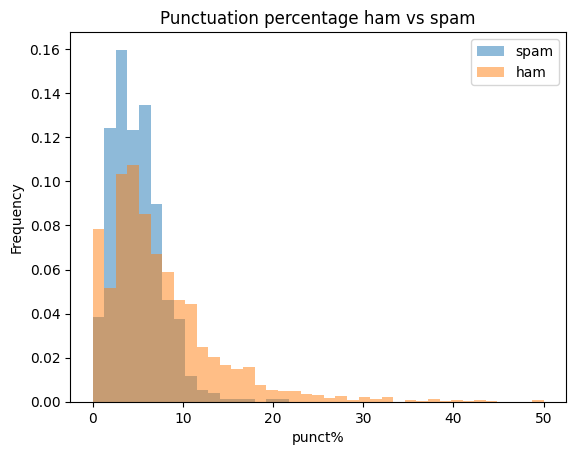

In [13]:
# Plot punct% for ham and spam messages
bins = np.linspace(0, 50, 40)
data.loc[data.label == 'spam', 'punct%'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'spam')
data.loc[data.label == 'ham', 'punct%'].plot(kind = 'hist', bins = bins, alpha = 0.5, density = True, label = 'ham')
plt.legend(loc = 'best')
plt.xlabel("punct%")
plt.title("Punctuation percentage ham vs spam")
plt.show()

### Cleaning text

### Turn words into lowercase letters only

In [14]:
"NLP" == "nlp"

False

In [15]:
"NLP".lower() == "nlp"

True

### Remove punctuation

In [16]:
"I love NLP" == "I love NLP."

False

In [17]:
# List of punctuations in the string library
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
# Remove punctuation
text = 'OMG! Did you see what happened to her? I was so shocked when I heard the news. :('
print(text)
text = "".join([word for word in text if word not in string.punctuation])
print(text)

OMG! Did you see what happened to her? I was so shocked when I heard the news. :(
OMG Did you see what happened to her I was so shocked when I heard the news 


### Tokenize words

In [21]:
# Available commands in the re library
dir(re)

['A',
 'ASCII',
 'DEBUG',
 'DOTALL',
 'I',
 'IGNORECASE',
 'L',
 'LOCALE',
 'M',
 'MULTILINE',
 'Match',
 'Pattern',
 'RegexFlag',
 'S',
 'Scanner',
 'T',
 'TEMPLATE',
 'U',
 'UNICODE',
 'VERBOSE',
 'X',
 '_MAXCACHE',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__version__',
 '_cache',
 '_compile',
 '_compile_repl',
 '_expand',
 '_locale',
 '_pickle',
 '_special_chars_map',
 '_subx',
 'compile',
 'copyreg',
 'enum',
 'error',
 'escape',
 'findall',
 'finditer',
 'fullmatch',
 'functools',
 'match',
 'purge',
 'search',
 'split',
 'sre_compile',
 'sre_parse',
 'sub',
 'subn',
 'template']

In [20]:
messy_text = 'This-is-a-made/up.string*to>>>>test----2""""""different~regex-methods'
re.split('\W+', messy_text)

['This',
 'is',
 'a',
 'made',
 'up',
 'string',
 'to',
 'test',
 '2',
 'different',
 'regex',
 'methods']

In [22]:
re.findall('\w+', messy_text)

['This',
 'is',
 'a',
 'made',
 'up',
 'string',
 'to',
 'test',
 '2',
 'different',
 'regex',
 'methods']

### Remove stopwords

In [23]:
import nltk
nltk.download('stopwords')
# Examples of stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:500:25]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'herself', 'been', 'with', 'here', 'very', 'doesn', 'won']

In [24]:
print(text)
print(text.lower().split())
print([word for word in text.lower().split() if word not in stopwords])

OMG Did you see what happened to her I was so shocked when I heard the news 
['omg', 'did', 'you', 'see', 'what', 'happened', 'to', 'her', 'i', 'was', 'so', 'shocked', 'when', 'i', 'heard', 'the', 'news']
['omg', 'see', 'happened', 'shocked', 'heard', 'news']


### Stemming vs lemmatization (word normalization)

In [25]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [26]:
print(ps.stem('goose'))
print(ps.stem('geese'))

goos
gees


In [27]:
import nltk
nltk.download('wordnet')

print(wn.lemmatize('goose'))
print(wn.lemmatize('geese'))

[nltk_data] Downloading package wordnet to /root/nltk_data...


goose
goose


### Putting everything together into a single clean_text function

In [28]:
# Create function for cleaning text
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    # text = [ps.stem(word) for word in tokens if word not in stopwords]
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

# Apply function to body_text
data['cleaned_text'] = data['body_text'].apply(lambda x: clean_text(x))
data[['body_text', 'cleaned_text']].head(10)

,body_text,cleaned_text
0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"
5,FreeMsg Hey there darling it's been 3 week's n...,"[freemsg, hey, darling, 3, week, word, back, i..."
6,Even my brother is not like to speak with me. ...,"[even, brother, like, speak, treat, like, aid,..."
7,As per your request 'Melle Melle (Oru Minnamin...,"[per, request, melle, melle, oru, minnaminungi..."
8,WINNER!! As a valued network customer you have...,"[winner, valued, network, customer, selected, ..."
9,Had your mobile 11 months or more? U R entitle...,"[mobile, 11, month, u, r, entitled, update, la..."


In [29]:
# Collect ham words
ham_words = list(data.loc[data.label == 'ham', 'cleaned_text'])

# Flatten list of lists
ham_words = list(np.concatenate(ham_words).flat)

# Create dictionary to store word frequency
ham_words = Counter(ham_words)
pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,u,1027
1,im,449
2,get,314
3,2,305
4,ltgt,276
5,go,273
6,ok,272
7,dont,257
8,come,242
9,know,241


In [30]:
# Collect spam words
spam_words = list(data.loc[data.label == 'spam', 'cleaned_text'])

# Flatten list of lists
spam_words = list(np.concatenate(spam_words).flat)

# Create dictionary to store word frequency
spam_words = Counter(spam_words)
pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,call,359
1,free,216
2,2,173
3,u,155
4,txt,150
5,ur,144
6,text,137
7,mobile,135
8,4,119
9,claim,115


In [31]:
# Define extra stopwords
extra_stopwords = ['u', 'im', '2', 'ur', 'ill', '4', 'lor', 'r', 'n', 'da', 'oh']

# Remove extra stopwords
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [word for word in x if word not in extra_stopwords])

Text(0.5, 1.0, '30 most common ham words')

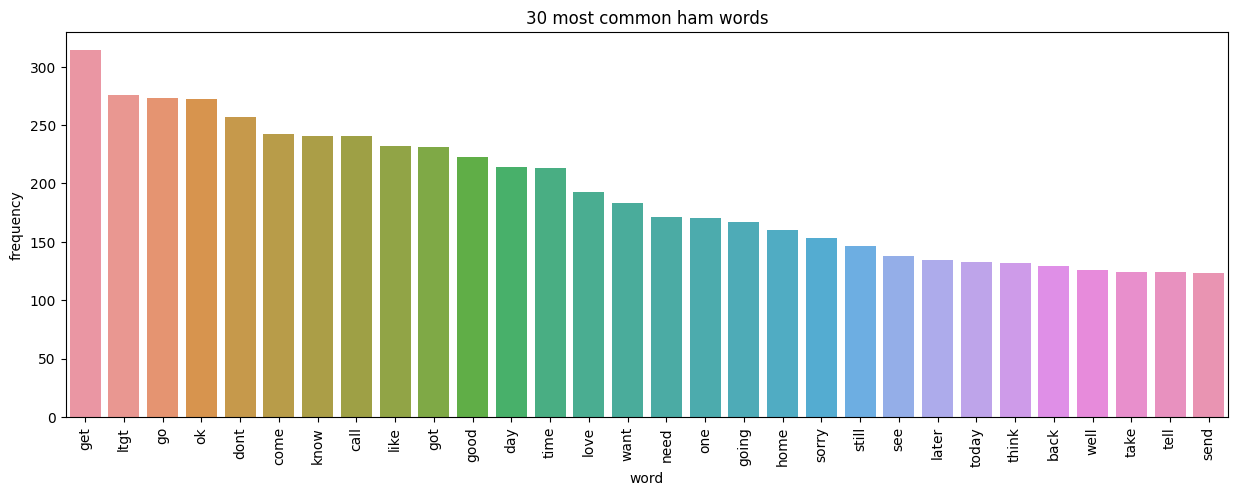

In [32]:
# Organise ham words data
ham_words = list(data.loc[data.label == 'ham', 'cleaned_text'])
ham_words = list(np.concatenate(ham_words).flat)
ham_words = Counter(ham_words)
ham_words = pd.DataFrame(ham_words.most_common(30), columns = ['word', 'frequency'])

# Plot most common harm words
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = ham_words, ax = ax)
plt.xticks(rotation = 90)
plt.title("30 most common ham words")

Text(0.5, 1.0, '30 most common spam words')

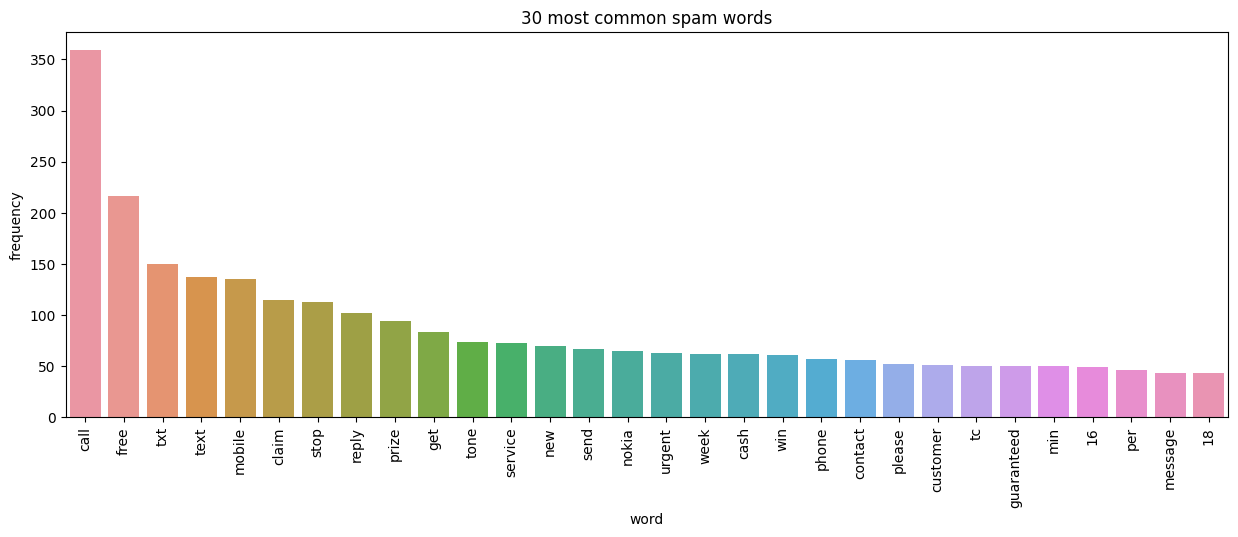

In [33]:
# Organise spam words data
spam_words = list(data.loc[data.label == 'spam', 'cleaned_text'])
spam_words = list(np.concatenate(spam_words).flat)
spam_words = Counter(spam_words)
spam_words = pd.DataFrame(spam_words.most_common(30), columns = ['word', 'frequency'])

# Plot most common harm words
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = spam_words, ax = ax)
plt.xticks(rotation = 90)
plt.title("30 most common spam words")

### Vectorization

### How (CountVectorizer + TfidfTransformer) works

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer
corpus = ['I love bananas', 'Bananas are so amazing!', 'Bananas go so well with pancakes']
count_vect = CountVectorizer()
corpus = count_vect.fit_transform(corpus)
name=count_vect.get_feature_names_out()
print(name)

['amazing' 'are' 'bananas' 'go' 'love' 'pancakes' 'so' 'well' 'with']


In [35]:
pd.DataFrame(corpus.toarray(), columns = count_vect.get_feature_names_out())

,amazing,are,bananas,go,love,pancakes,so,well,with
0,0,0,1,0,1,0,0,0,0
1,1,1,1,0,0,0,1,0,0
2,0,0,1,1,0,1,1,1,1


In [36]:
# TfidfTransformer
tfidf_transformer = TfidfTransformer()
corpus = tfidf_transformer.fit_transform(corpus)
pd.DataFrame(corpus.toarray(), columns = count_vect.get_feature_names_out())

,amazing,are,bananas,go,love,pancakes,so,well,with
0,0.000000,0.000000,0.508542,0.000000,0.861037,0.000000,0.000000,0.000000,0.000000
1,0.584483,0.584483,0.345205,0.000000,0.000000,0.000000,0.444514,0.000000,0.000000
2,0.000000,0.000000,0.266075,0.450504,0.000000,0.450504,0.342620,0.450504,0.450504


### How TfidfVectorizer works

In [37]:
# TfidfVectorizer
corpus = ['I love bananas', 'Bananas are so amazing!', 'Bananas go so well with pancakes']
tfidf_vect = TfidfVectorizer()
corpus = tfidf_vect.fit_transform(corpus)
pd.DataFrame(corpus.toarray(), columns = tfidf_vect.get_feature_names_out())

,amazing,are,bananas,go,love,pancakes,so,well,with
0,0.000000,0.000000,0.508542,0.000000,0.861037,0.000000,0.000000,0.000000,0.000000
1,0.584483,0.584483,0.345205,0.000000,0.000000,0.000000,0.444514,0.000000,0.000000
2,0.000000,0.000000,0.266075,0.450504,0.000000,0.450504,0.342620,0.450504,0.450504


### Modelling

### Train-test-split approach

In [38]:
data.head()

,label,body_text,body_len,punct%,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,"[go, jurong, point, crazy, available, bugis, g..."
1,ham,Ok lar... Joking wif u oni...,24,25.0,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,39,15.4,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,"[nah, dont, think, go, usf, life, around, though]"


In [39]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data.label, random_state = 42, test_size = 0.2)

# Check shape
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (4457, 3)
Y_train shape: (4457,)
X_test shape: (1115, 3)
Y_test shape: (1115,)


In [40]:
# Instantiate and fit TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

# Use fitted TfidfVectorizer to transform body text in X_train and X_test
tfidf_train = tfidf_vect.transform(X_train['body_text'])
tfidf_test = tfidf_vect.transform(X_test['body_text'])

# Recombine transformed body text with body_len and punct% features
X_train = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_train.toarray())], axis = 1)
X_test = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_test.toarray())], axis = 1)

# Check shape
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (4457, 7865)
Y_train shape: (4457,)
X_test shape: (1115, 7865)
Y_test shape: (1115,)


In [41]:
# Default random forest
print(RandomForestClassifier())

RandomForestClassifier()


In [42]:
# Manual grid search for random forest
def explore_rf_params(n_est, depth):
    rf = RandomForestClassifier(n_estimators = n_est, max_depth = depth, n_jobs = -1, random_state = 42)
    rf_model = rf.fit(X_train, Y_train)
    Y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
    print(f"Est: {n_est} / Depth: {depth} ---- Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

# Convert feature names to strings if they are not already strings
X_train.columns = X_train.columns.astype(str)

# Convert feature names to strings if they are not already strings
X_test.columns = X_test.columns.astype(str)

for n_est in [50, 100, 150]:
    for depth in [10, 20, 30, None]:
        explore_rf_params(n_est, depth)

Est: 50 / Depth: 10 ---- Precision: 1.0 / Recall: 0.253 / Accuracy: 0.9
Est: 50 / Depth: 20 ---- Precision: 1.0 / Recall: 0.547 / Accuracy: 0.939
Est: 50 / Depth: 30 ---- Precision: 1.0 / Recall: 0.687 / Accuracy: 0.958
Est: 50 / Depth: None ---- Precision: 1.0 / Recall: 0.847 / Accuracy: 0.979
Est: 100 / Depth: 10 ---- Precision: 1.0 / Recall: 0.28 / Accuracy: 0.903
Est: 100 / Depth: 20 ---- Precision: 1.0 / Recall: 0.553 / Accuracy: 0.94
Est: 100 / Depth: 30 ---- Precision: 1.0 / Recall: 0.693 / Accuracy: 0.959
Est: 100 / Depth: None ---- Precision: 1.0 / Recall: 0.833 / Accuracy: 0.978
Est: 150 / Depth: 10 ---- Precision: 1.0 / Recall: 0.253 / Accuracy: 0.9
Est: 150 / Depth: 20 ---- Precision: 1.0 / Recall: 0.527 / Accuracy: 0.936
Est: 150 / Depth: 30 ---- Precision: 1.0 / Recall: 0.693 / Accuracy: 0.959
Est: 150 / Depth: None ---- Precision: 1.0 / Recall: 0.827 / Accuracy: 0.977


In [43]:
# Instantiate RandomForestClassifier with optimal set of hyperparameters
rf = RandomForestClassifier(n_estimators = 100, max_depth = None, random_state = 42, n_jobs = -1)

# Fit model
start = time.time()
rf_model = rf.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict
start = time.time()
Y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 5.546 / Predict time: 0.089
Precision: 1.0 / Recall: 0.833 / Accuracy: 0.978


<Axes: >

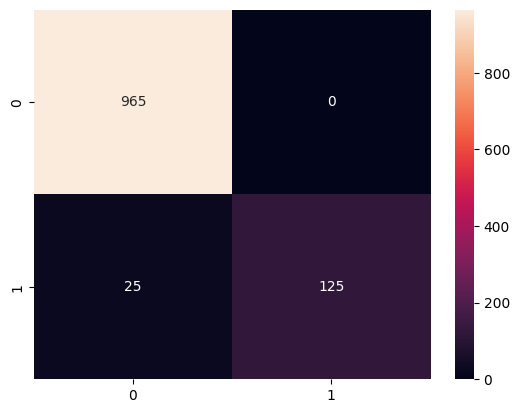

In [44]:
# Confusion matrix for RandomForestClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

### GradientBoostingClassifier

In [45]:
# Default gradient boosting
print(GradientBoostingClassifier())

GradientBoostingClassifier()


In [46]:
# Instantiate GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state = 42)

# Fit model
start = time.time()
gb_model = gb.fit(X_train, Y_train)
end = time.time()
fit_time = end - start

# Predict
start = time.time()
Y_pred = gb_model.predict(X_test)
end = time.time()
pred_time = end - start

# Time and prediction results
precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)}")

Fit time: 30.65 / Predict time: 0.072
Precision: 0.953 / Recall: 0.813 / Accuracy: 0.97


<Axes: >

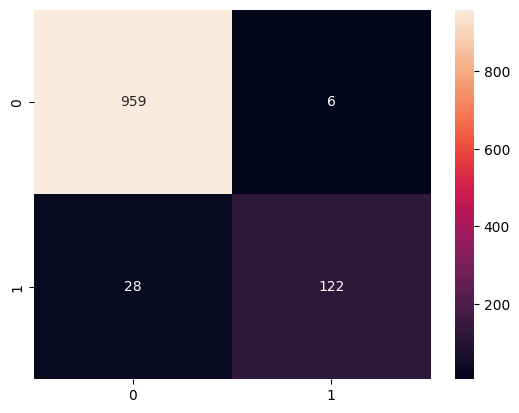

In [47]:
# Confusion matrix for GradientBoostingClassifier
matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(matrix, annot = True, fmt = 'd')

### Pipeline approach

In [48]:
# Instantiate TfidfVectorizer, RandomForestClassifier and GradientBoostingClassifier
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
gb = GradientBoostingClassifier(random_state = 42)

# Make columns transformer
transformer = make_column_transformer((tfidf_vect, 'body_text'), remainder = 'passthrough')

# Build two separate pipelines for RandomForestClassifier and GradientBoostingClassifier
rf_pipeline = make_pipeline(transformer, rf)
gb_pipeline = make_pipeline(transformer, gb)

# Perform 5-fold cross validation and compute mean score
rf_score = cross_val_score(rf_pipeline, data[['body_text', 'body_len', 'punct%']], data.label, cv = 5, scoring = 'accuracy', n_jobs = -1)
gb_score = cross_val_score(gb_pipeline, data[['body_text', 'body_len', 'punct%']], data.label, cv = 5, scoring = 'accuracy', n_jobs = -1)
print(f"Random forest score: {round(mean(rf_score), 3)}")
print(f"Gradient boosting score: {round(mean(gb_score), 3)}")

Random forest score: 0.973
Gradient boosting score: 0.962
